# Topic extraction

Using `tomotopy`'s LDA implementation.
Comparing different number of topics and evaluating coherence.

In [1]:
%load_ext autotime

import psycopg2
import numpy 
import nltk
import wordcloud
import matplotlib.pyplot as plt
import gensim
from tqdm import tqdm
import multiprocessing

DATASET_NAME = 'full-lemma-nophra'
n_iterations = 250
test_ratio = 0.2

In [2]:
import pickle

print('Loading dataset...')
dataset = pickle.load(open('dataset.small.pkl', 'rb'))
data_train = dataset['train']
data_test  = dataset['test']

print("Building gensim corpus...")
gensim_dictionary = gensim.corpora.Dictionary(data_train)

print(f'{len(data_train)} training documents')
print(f'{len(data_test)} test documents')

Loading dataset...
Building gensim corpus...
7253 training documents
1814 test documents
time: 337 ms


In [3]:
import tomotopy as tp

def prepare_model(k):
    model = tp.LDAModel(
        tw=tp.TermWeight.ONE,
        k=k,
        seed=0
    )

    for tokens in tqdm(data_train):
        model.add_doc(tokens)
    
    return model

time: 175 ms


In [4]:
# https://towardsdatascience.com/dont-be-afraid-of-nonparametric-topic-models-part-2-python-e5666db347a
# https://github.com/ecoronado92/towards_data_science/blob/master/hdp_example/scripts/model_funcs.py

def get_topic_words(model, top_n=10):
    '''Wrapper function to extract topics from trained tomotopy HDP model 
    
    ** Inputs **
    model:obj -> trained model
    top_n: int -> top n words in topic based on frequencies
    
    ** Returns **
    topics: dict -> per topic, an arrays2 with top words and associated frequencies 
    '''
    
    # Get most important topics by # of times they were assigned (i.e. counts)
    sorted_topics = range(model.k)
    
    topics=dict()
    
    # For topics found, extract only those that are still assigned
    for k in sorted_topics:
        try:
            if not model.is_live_topic(k): continue # remove un-assigned topics at the end (i.e. not alive)
        except AttributeError: 
            pass
        
        topic_wp = model.get_topic_words(k, top_n=top_n)

        topics[k] = topic_wp # store topic word/frequency array
        
    return topics



def eval_coherence(topics_dict, vocab, documents, coherence_type='c_v'):
    '''Wrapper function that uses gensim Coherence Model to compute topic coherence scores
    
    ** Inputs **
    topic_dict: dict -> topic dictionary from train_HDPmodel function
    vocab: gensim.corpora.Dictionary
    documents: list of list of strings
    coherence_typ: str -> type of coherence value to comput (see gensim for opts)
    
    ** Returns **
    3-tuple,
        float -> coherence value
        float list -> per-topic coherence
        float list -> per-topic coherence deviation
    '''
    
    # Build topic list from dictionary
    topic_list=[]
    for k, tups in topics_dict.items():
        topic_tokens = [w for w,p in tups]
        topic_list.append(topic_tokens)
            

    # Build Coherence model
    cm = gensim.models.CoherenceModel(
        topics=topic_list,
        dictionary=vocab,
        texts=documents, 
        coherence=coherence_type,
        processes=16)
    
    return cm.get_coherence()


time: 1.75 ms


In [5]:
#
# FIXME:
# only consider a topic when its score is > some threshold (2x 1/20 ?)

def topic_counts(model, top_n):
    """For each topic, count posts where the topic figure in the `top_n` topics
    
    Returns:
    dict of topic_id (int), posts (int)
    """
    counts = {}
    threshold = 2.0 / model.k
    for k in range(model.k):
        counts[k] = 0
    for doc in tqdm(model.docs):
        for k, v in doc.get_topics(top_n=top_n):
            if v < threshold: next
            counts[k] += 1
    return counts

time: 12.3 ms


In [6]:
# http://qpleple.com/perplexity-to-evaluate-topic-models/
import math

def model_perplexity(model, samples):
    count = 0
    docs = [model.make_doc(s) for s in samples]
    _, log_likelihoods = model.infer(doc=docs)
    lengths = [len(s) for s in samples]
    
    assert len(lengths) == len(log_likelihoods)
    return math.exp(- numpy.sum(numpy.array(log_likelihoods)) / numpy.sum(numpy.array(lengths)))


time: 9.57 ms


In [7]:
models = {}
reported_perplexity = {}
train_perplexity = {}
test_perplexity = {}
coherence_c_v = {}
coherence_u_mass = {}

k_values = list(reversed(range(2,5)))
n_iterations = 50

print('Preparing models...')
for k in k_values:
    models[k] = prepare_model(k)

print('Training models...')
for iter in tqdm(range(0, n_iterations)):
    for k,model in models.items():
        model.train(1)

print('Saving reported perplexity...')
for k,model in models.items():
    reported_perplexity[k] = model.perplexity

print('Calculating model metrics...')
def compute_perplexity(k):
    model = models[k]
    p0 = model_perplexity(model, data_train)
    p1 = model_perplexity(model, data_test)

    return (k, p0, p1)

with multiprocessing.Pool(processes=8) as pool:
    for k, p0, p1 in pool.imap_unordered(compute_perplexity, tqdm(k_values)):
        train_perplexity[k] = p0
        test_perplexity[k]  = p1

print('Calculating coherence...')
for k, model in tqdm(models.items()):
    cv = eval_coherence(get_topic_words(model), gensim_dictionary, data_train, coherence_type='c_v')
    cu = eval_coherence(get_topic_words(model), gensim_dictionary, data_train, coherence_type='u_mass')    
    coherence_c_v[k]    = cv
    coherence_u_mass[k] = cu

  0%|          | 0/50 [00:00<?, ?it/s]

Preparing models...
Training models...


100%|██████████| 50/50 [00:01<00:00, 28.94it/s]

Saving reported perplexity...
Calculating model metrics...



  0%|          | 0/3 [00:00<?, ?it/s]

Calculating coherence...


100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

time: 4.28 s


In [8]:
print(train_perplexity)
print(test_perplexity)
print(coherence_c_v)
print(coherence_u_mass)

{2: 2047.662099964341, 3: 2204.189947930309, 4: 2137.5812086741958}
{2: 1373.404589891262, 3: 1512.5981445813693, 4: 1514.4886826093011}
{4: 0.47182649539259935, 3: 0.47296640766511144, 2: 0.45981641842599535}
{4: -1.7342557761992285, 3: -1.566364422521661, 2: -1.4589148200357147}
time: 697 µs


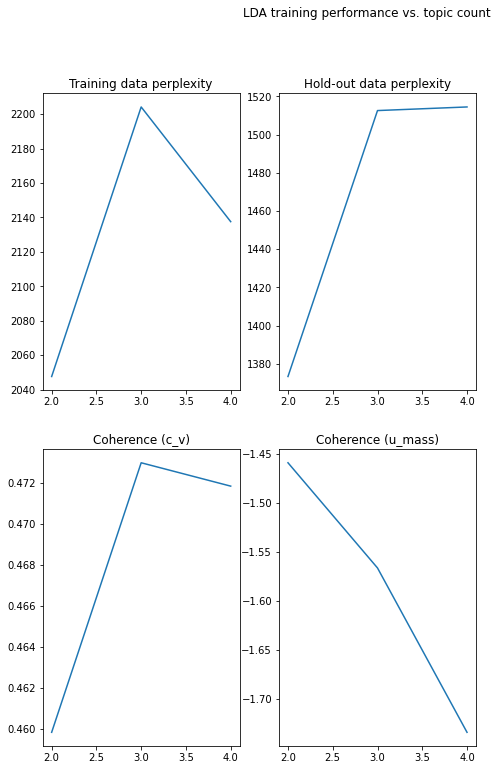

time: 366 ms


In [9]:
fig = plt.figure(figsize=(12,12))
fig.suptitle('LDA training performance vs. topic count')

x = list(train_perplexity.keys())
y = list(train_perplexity.values())

plt.subplot(231)
plt.plot(x,y)
plt.title('Training data perplexity')

x = list(test_perplexity.keys())
y = list(test_perplexity.values())

plt.subplot(232)
plt.plot(x,y)
plt.title('Hold-out data perplexity')

x = list(coherence_c_v.keys())
y = list(coherence_c_v.values())

plt.subplot(234)
plt.plot(x,y)
plt.title('Coherence (c_v)')

x = list(coherence_u_mass.keys())
y = list(coherence_u_mass.values())

plt.subplot(235)
plt.plot(x,y)
plt.title('Coherence (u_mass)')

plt.show()

